In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [3]:
from helper.object_detection_helper import *
from loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from models.RetinaNet import RetinaNet

In [4]:
dots = Path('/data/Datasets/LineArrayTiny/')

In [5]:
dots

PosixPath('/data/Datasets/LineArrayTiny')

In [6]:
images, lbl_bbox = get_annotations(dots/'train.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [7]:
def bb_pad_collate(samples:BatchSamples, pad_idx:int=0) -> Tuple[FloatTensor, Tuple[LongTensor, LongTensor]]:
    "Function that collect `samples` of labelled bboxes and adds padding with `pad_idx`."
    samples = [s for s in samples if s[1].data[0].shape[0] > 0] # check that labels are available

    max_len = max([len(s[1].data[1]) for s in samples])
    bboxes = torch.zeros(len(samples), max_len, 4)
    labels = torch.zeros(len(samples), max_len).long() + pad_idx
    imgs = []
    for i,s in enumerate(samples):
        imgs.append(s[0].data[None])
        bbs, lbls = s[1].data
        bboxes[i,-len(lbls):] = bbs
        labels[i,-len(lbls):] = torch.from_numpy(lbls)
    return torch.cat(imgs,0), (bboxes,labels)

In [8]:
data = (ObjectItemList.from_folder(dots)
        #Where are the images? -> in coco
        .random_split_by_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), tfm_y=True, size=256)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=64, collate_fn=bb_pad_collate))
        #Finally we convert to a DataBunch and we use bb_pad_collate
#data = data.normalize()

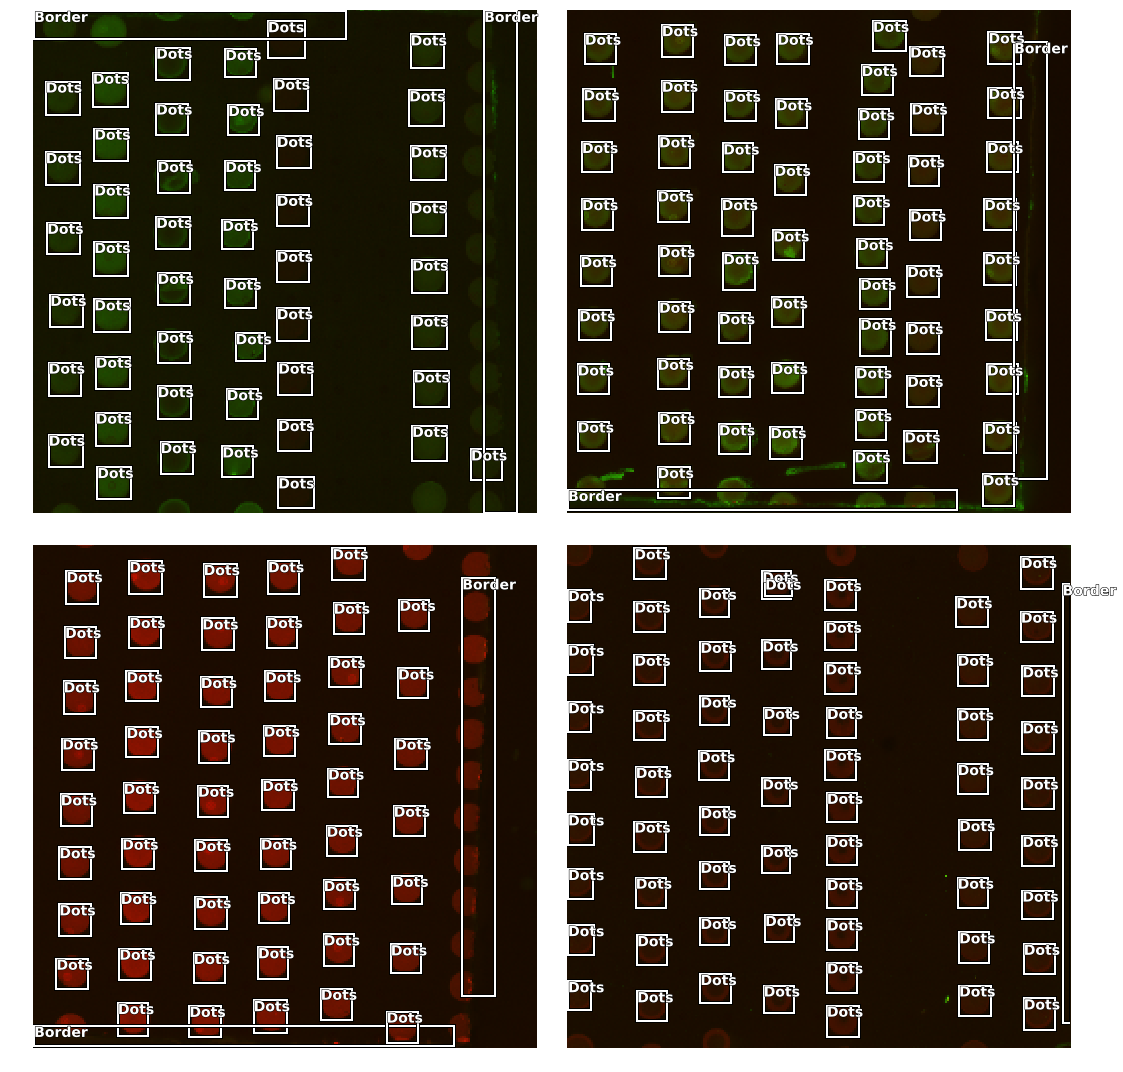

In [9]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(15,15))

In [169]:
n_classes = data.train_ds.c
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes, n_anchors=1, sizes=[32], chs=16, n_conv=1)
model.eval()

RetinaNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [20]:
x = torch.randn(2,3,256,256)
output = model(x)

In [22]:
output[0][0]

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SelectBackward>)

In [11]:
print([y.size() for y in output[:2]], output[2])

[torch.Size([2, 768, 2]), torch.Size([2, 768, 4])] [[16, 16]]


In [12]:
'''
(16, 16) scales [0.15]  ratios  [1]
(16, 16) scales [0.5]   ratios  [10]
(16, 16) scales [0.5]   ratios = [0.1]
'''

'\n(16, 16) scales [0.15]  ratios  [1]\n(16, 16) scales [0.5]   ratios  [10]\n(16, 16) scales [0.5]   ratios = [0.1]\n'

In [13]:
ratios = [1, 10, 0.1]

In [14]:
scales = [0.15, 0.5]

In [15]:
sizes = [(16, 16)]# [(32, 32),(16, 16), (8, 8), (4, 4), (2, 2)]

In [9]:
anchors_dots = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.5, 0.7]) # Dots
#anchors_borders = create_anchors(sizes=[(16,16)], ratios=[10, 0.1], scales=[0.5]) # border

In [10]:
anchors_dots

tensor([[-0.9688, -0.9688,  0.1250,  0.1250],
        [-0.9688, -0.9688,  0.1750,  0.1750],
        [-0.9688, -0.9062,  0.1250,  0.1250],
        ...,
        [ 0.9688,  0.9062,  0.1750,  0.1750],
        [ 0.9688,  0.9688,  0.1250,  0.1250],
        [ 0.9688,  0.9688,  0.1750,  0.1750]])

In [11]:
anchors = anchors_dots

In [11]:
anchors = torch.cat((anchors_dots, anchors_borders), 0)

In [43]:
anchors.size()

torch.Size([768, 4])

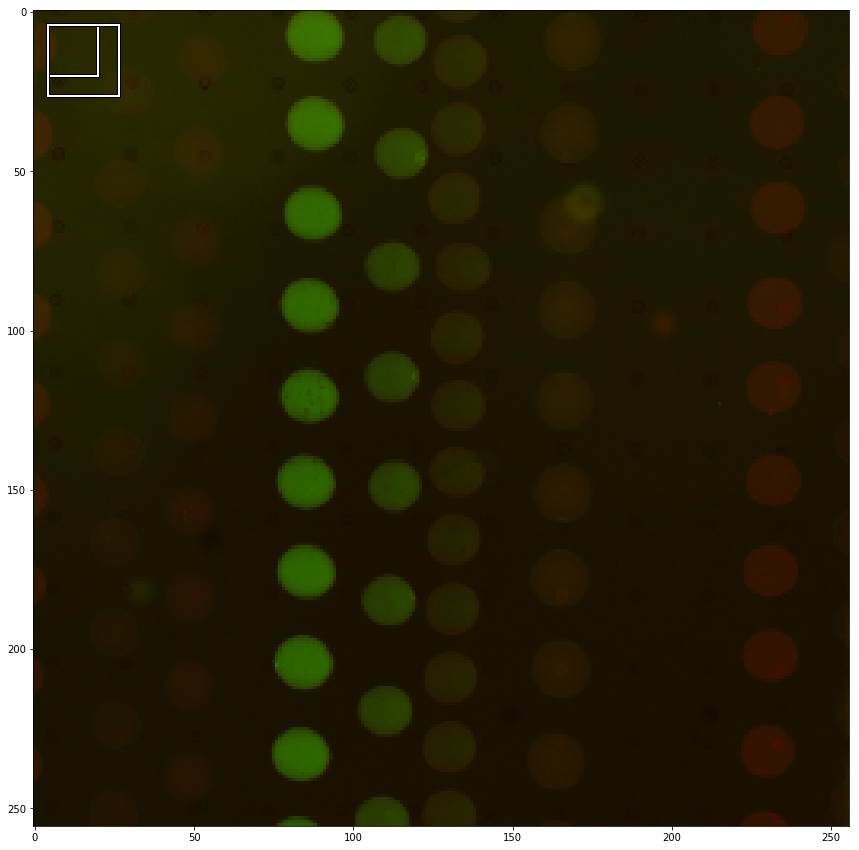

In [147]:
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors_dots[:2]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * 256 / 2 
    y = (bb[1] + 1) * 256 / 2 
    w = bb[2] * 256 / 2
    h = bb[3] * 256 / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

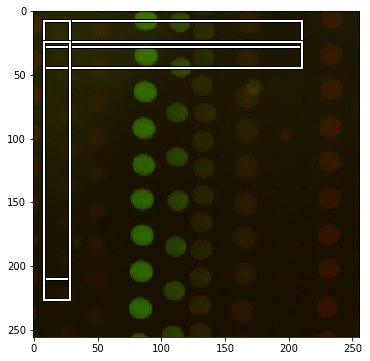

In [95]:
fig,ax = plt.subplots(figsize=(6,6))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors_borders[:4]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * 256 / 2 
    y = (bb[1] + 1) * 256 / 2 
    w = bb[2] * 256
    h = bb[3] * 256
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

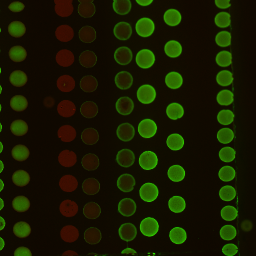

In [102]:
data.train_ds[1][0]

In [12]:
class LossMetrics(LearnerCallback):
    "Add `loss_func.metrics` to metrics named by `loss_func.metric_names`"
    _order = -20 #Needs to run before the recorder

    def on_train_begin(self, **kwargs):
        "Add the metrics names to the `Recorder`."
        self.names = ifnone(self.learn.loss_func.metric_names, [])
        if not self.names: warn('LossMetrics requested by no loss_func.metric_names provided')
        self.learn.recorder.add_metric_names(self.names)

    def on_epoch_begin(self, **kwargs):
        "Initialize the metrics for this epoch."
        self.metrics = {name:0. for name in self.names}
        self.nums = 0

    def on_batch_end(self, last_target, train, **kwargs):
        "Update the metrics if not `train`"
        if train: return
        bs = last_target[0].size(0)
        for name in self.names:
            self.metrics[name] += bs * self.learn.loss_func.metrics[name].detach().cpu()
        self.nums += bs

    def on_epoch_end(self, **kwargs):
        "Finish the computation and sends the result to the Recorder."
        if not self.nums: return
        metrics = [self.metrics[name]/self.nums for name in self.names]
        self.learn.recorder.add_metrics(metrics)

In [13]:
crit = RetinaNetFocalLoss(anchors)

In [14]:
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=2, sizes=[32], chs=16, final_bias=-4., n_conv=1)

In [15]:
learn = Learner(data, model, loss_func=crit, callback_fns=[ShowGraph, LossMetrics]) 

In [16]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


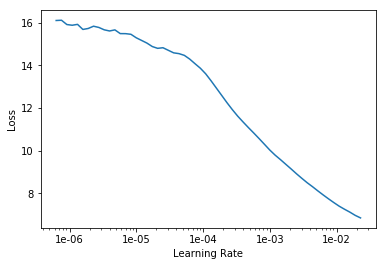

In [17]:
learn.lr_find()
learn.recorder.plot()

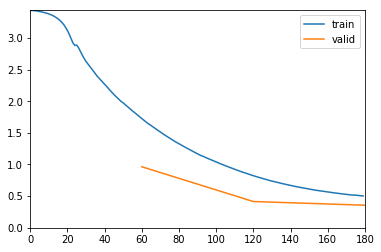

In [17]:
learn.fit_one_cycle(3, 1e-3)

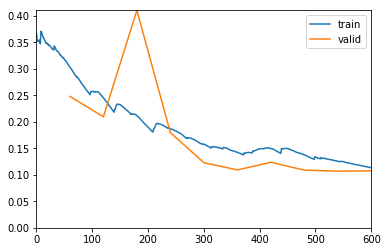

In [18]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

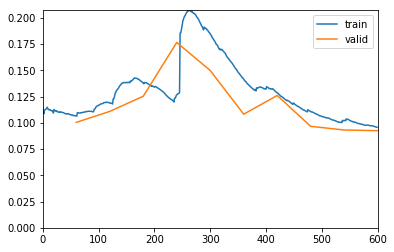

In [22]:
learn.fit_one_cycle(10, 1e-3)

In [89]:
learn.save('Dots')

In [19]:
classes = data.train_ds.classes

In [20]:
classes

['background', 'Border', 'Dots']

In [33]:
img_batch,target = next(iter(data.valid_dl))

In [34]:
img_batch.shape

torch.Size([64, 3, 256, 256])

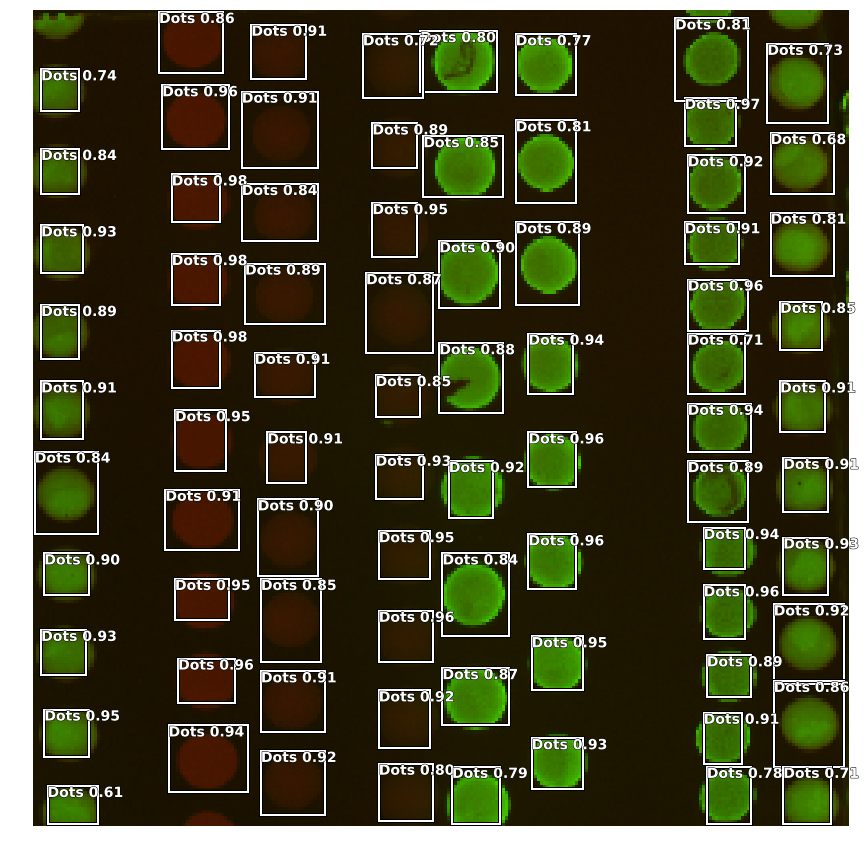

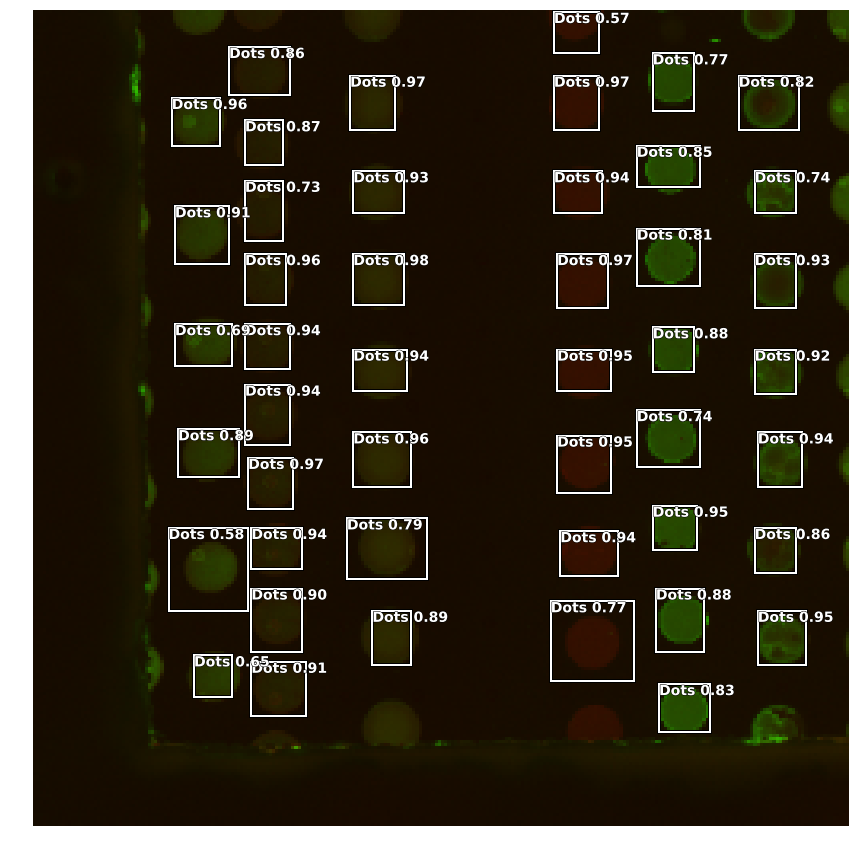

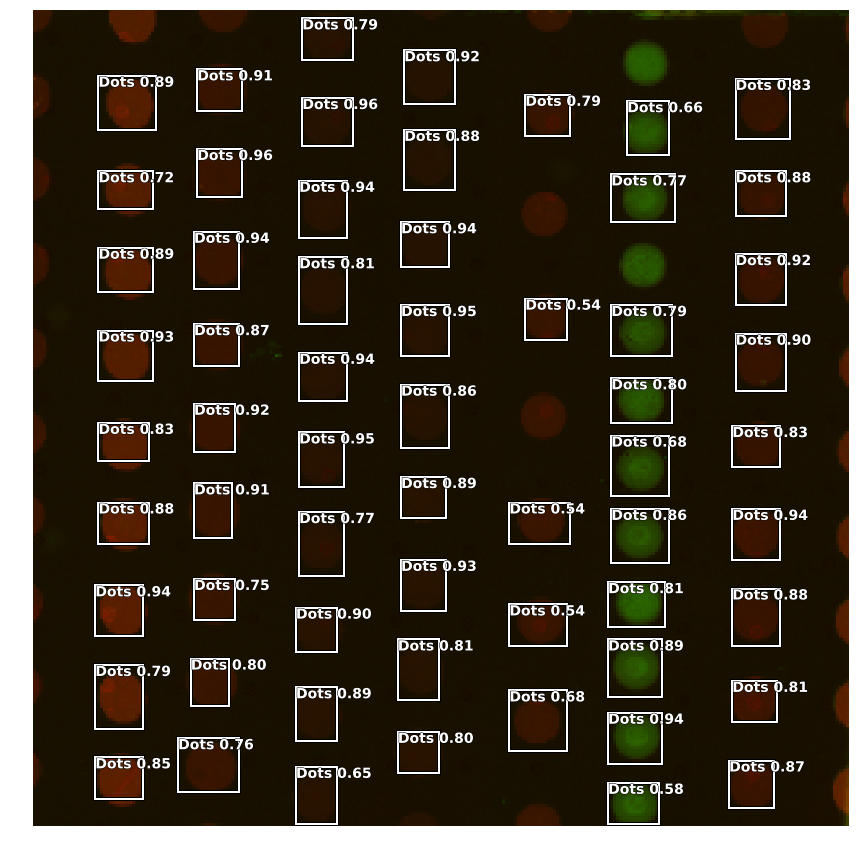

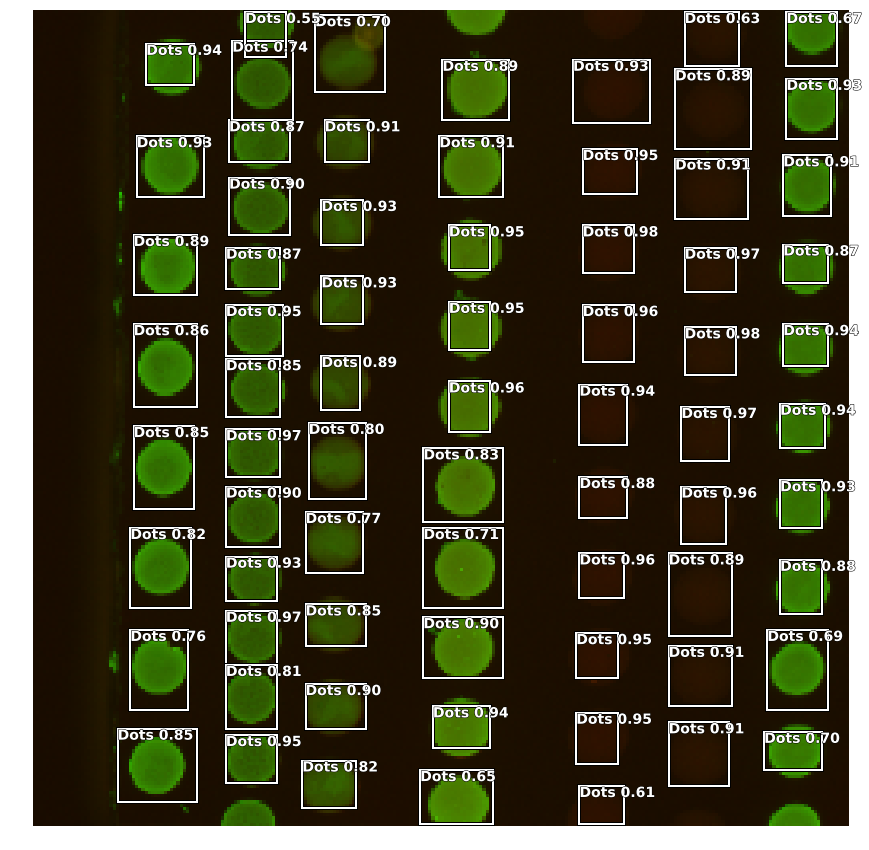

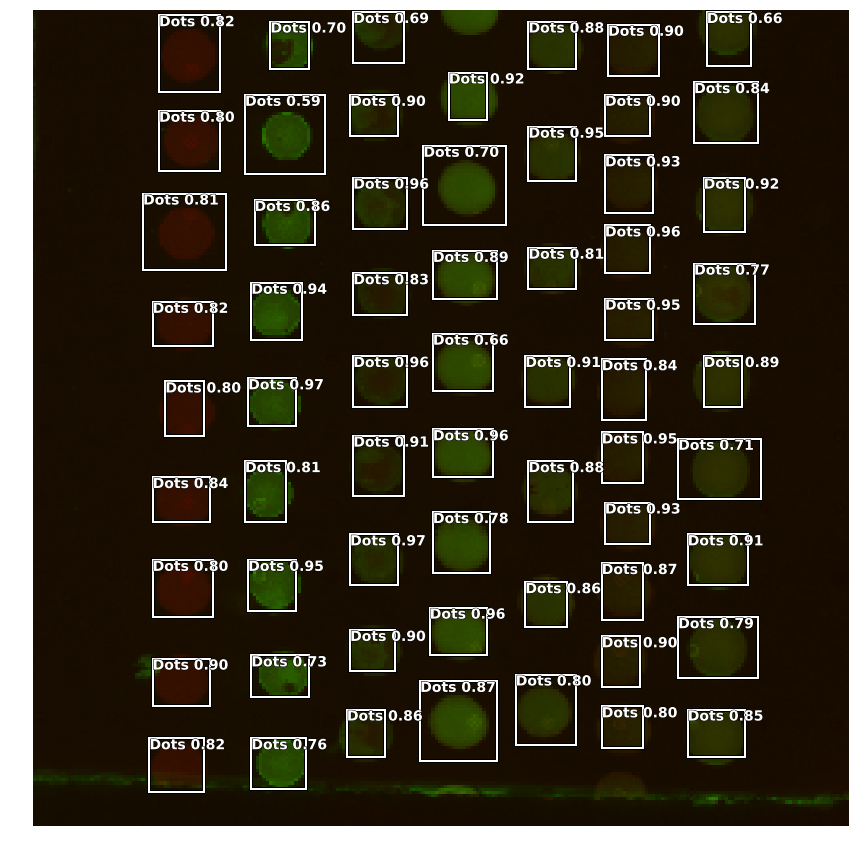

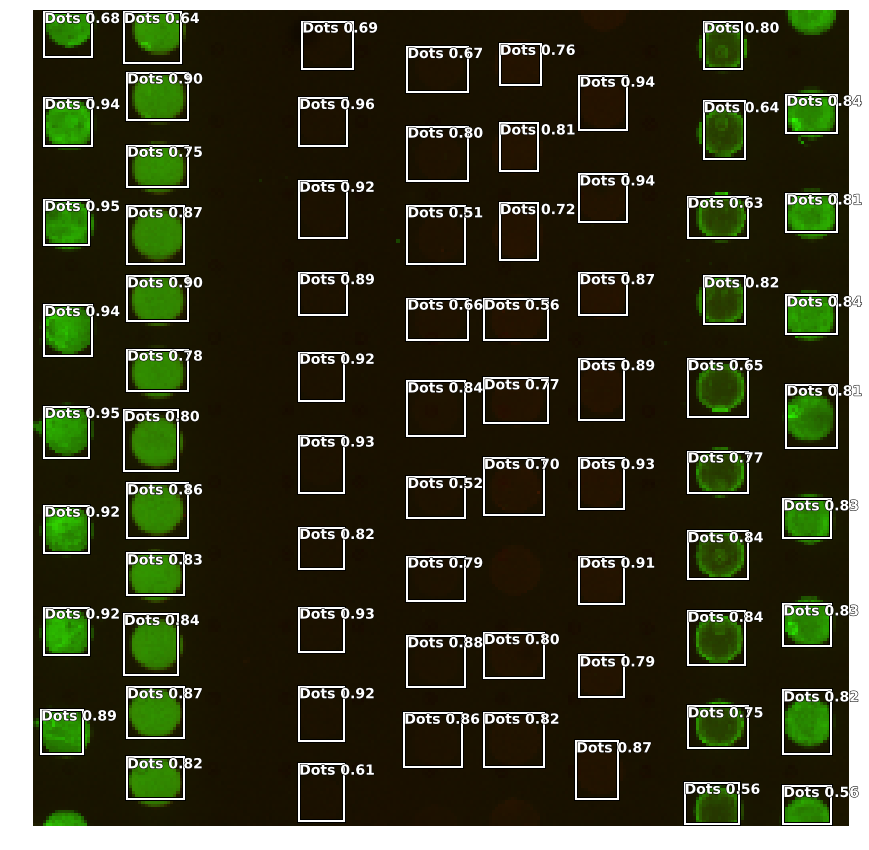

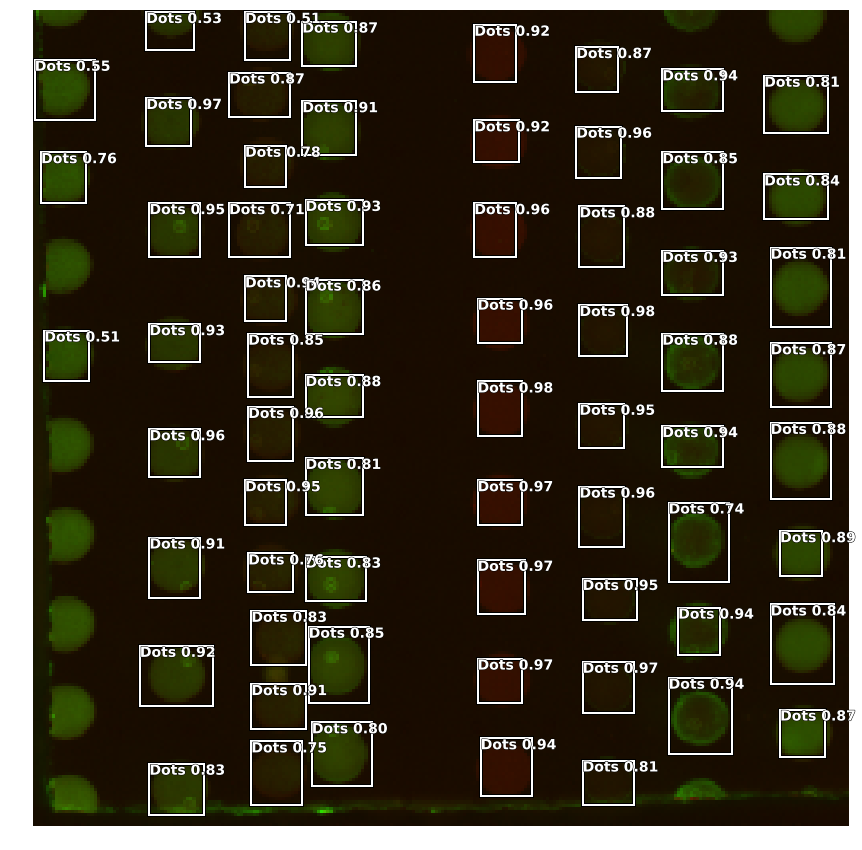

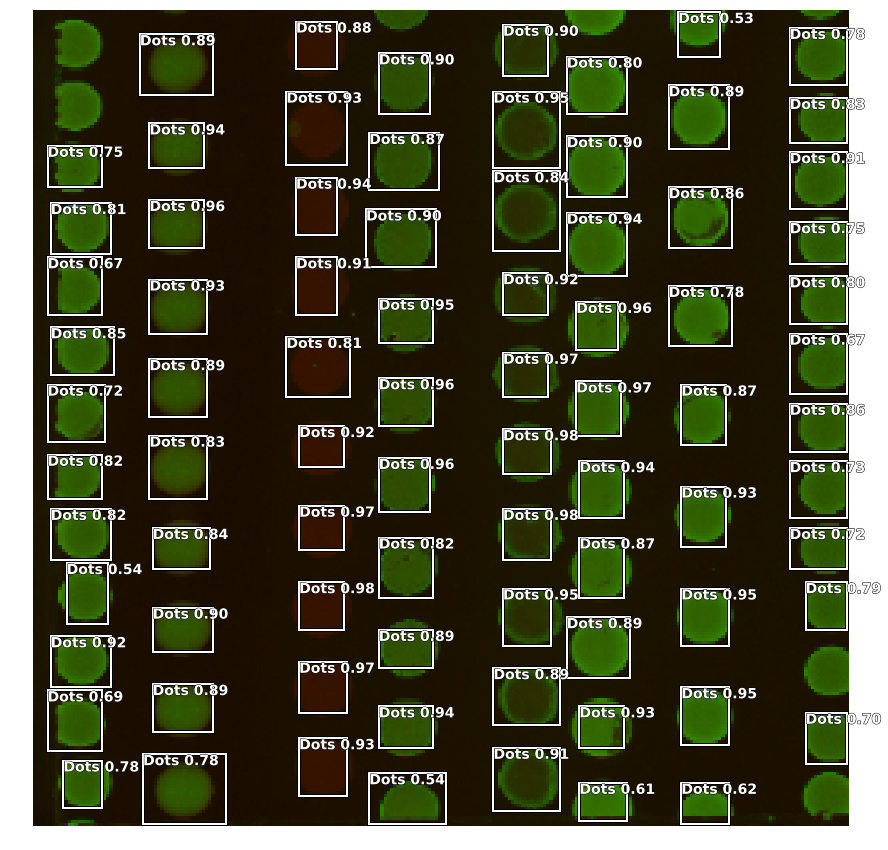

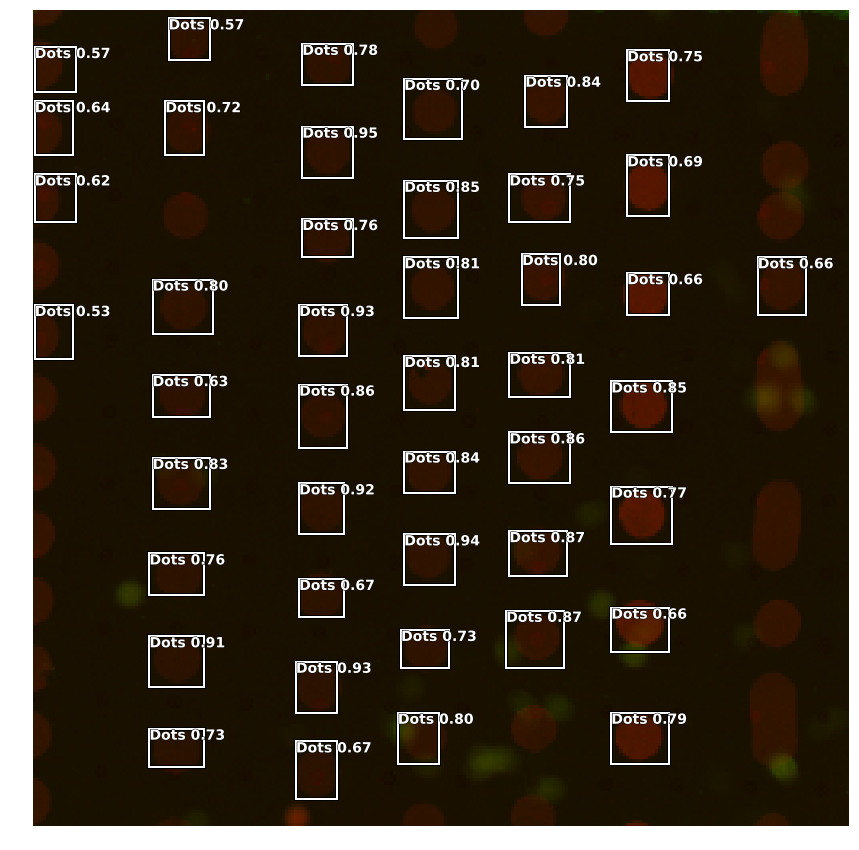

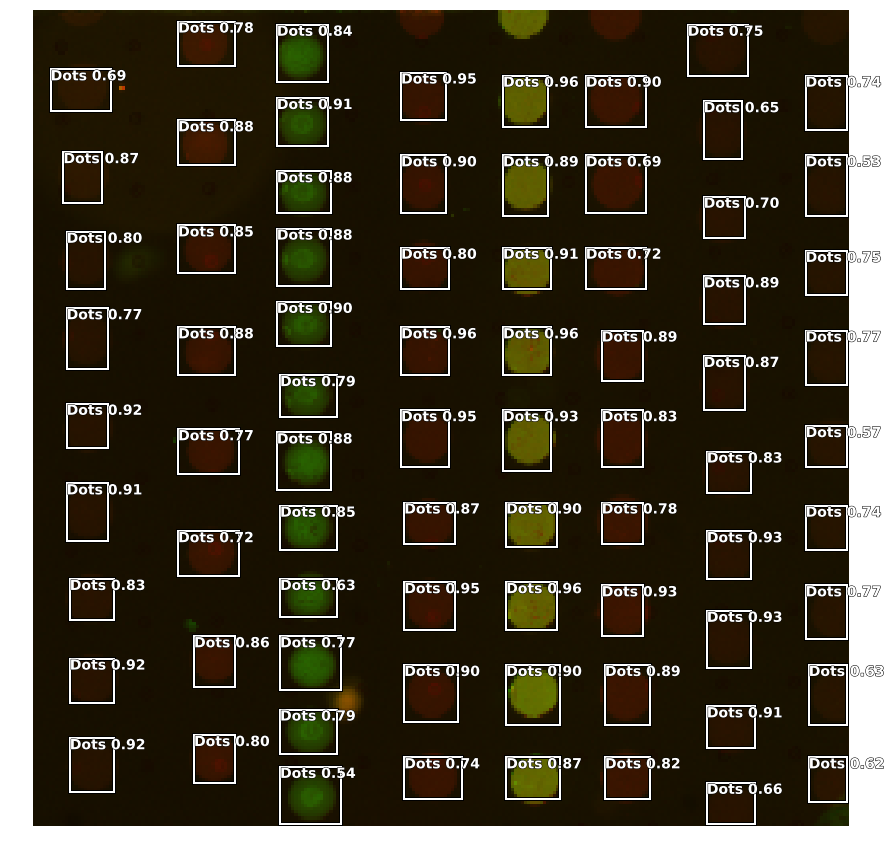

In [23]:
img_batch,target = next(iter(data.valid_dl))
with torch.no_grad():
    output = model(img_batch[:10])
    for idx in range(len(output[0])):
        img = data.valid_ds[idx][0] 
        clas_pred = output[0][idx]
        bbox_pred = output[1][idx]

        bbox_pred, scores, preds = process_output(clas_pred, bbox_pred, anchors, 0.5)
        if bbox_pred is None:
            continue
            
        to_keep = nms(bbox_pred, scores, 0.1)
        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()

        t_sz = torch.Tensor([*img.size])[None].float()
        bbox_pred[:, :2] = bbox_pred[:, :2] - bbox_pred[:, 2:] / 2
        bbox_pred[:, :2] = (bbox_pred[:, :2] + 1) * t_sz / 2
        bbox_pred[:, 2:] = bbox_pred[:, 2:] * t_sz / 2
        bbox_pred = bbox_pred.long()

        show_preds(img, bbox_pred, preds, scores, classes, (15,15))